# Wine prices prediction

## Get data

In [2]:
import pandas as pd
import requests
from datetime import datetime
import openpyxl
# Define FRED API key
api_key = 'db26981c344747951316ccd9c7d01f0d'

In [8]:
# Function to download data from FRED
def download_fred_data(series_id, api_key):
    url = f"https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json"
    response = requests.get(url)
    data = response.json()
    df = pd.DataFrame(data['observations'])
    df['date'] = pd.to_datetime(df['date'])
    df.set_index('date', inplace=True)

    # Clean data: replace '.' with NaN and convert to float
    df['value'] = pd.to_numeric(df['value'], errors='coerce')

    return df[['value']]

# Define series IDs for FRED data
fred_series_ids = {
    'Average Wine Price': 'APU0000720311',
    'GDP': 'GDP',
    'Unemployment Rate': 'UNRATE',
    'Retail Sales': 'RSAFS',
    'Durable Goods Orders': 'DGORDER',
    'Money Supply (M1)': 'WM1NS',
    'Federal Funds Rate': 'FEDFUNDS',
    'Consumer Price Index (CPI)': 'CPIAUCSL',
    'S&P 500 Index': 'SP500',
    'Personal Consumption Expenditures': 'PCE',
    'Disposable Personal Income': 'DPI',
    'Consumer Confidence Index': 'UMCSENT',
    'Producer Price Index': 'PPIACO',
    'Industrial Production Index': 'INDPRO',
    'Total Nonfarm Payrolls': 'PAYEMS',
    'Housing Starts': 'HOUST',
    '10-Year Treasury Constant Maturity Rate': 'GS10',
    'Corporate Profits After Tax': 'CP',
    'Personal Savings Rate': 'PSAVERT'

}

# Download FRED data
fred_data = {}
for name, series_id in fred_series_ids.items():
    fred_data[name] = download_fred_data(series_id, api_key)

# Combine all data into a single DataFrame
combined_df = pd.concat(fred_data.values(), axis=1)
combined_df.columns = fred_data.keys()

# Filter data to include only rows on or after 1 January 1996
start_date = '1996-01-01'
filtered_df = combined_df[combined_df.index >= start_date]

# Resample data to monthly frequency
monthly_df = filtered_df.resample('M').mean()

# Create data dictionary
data_dict = pd.DataFrame({
    'Variable Name': list(fred_series_ids.keys()),
    'FRED Series ID': list(fred_series_ids.values()),
    'Description': [
        'Average Wine Price',
        'Gross Domestic Product',
        'Unemployment Rate',
        'Retail Sales',
        'Durable Goods Orders',
        'Money Supply (M1)',
        'Federal Funds Rate',
        'Consumer Price Index',
        'S&P 500 Index',
        'Personal Consumption Expenditures',
        'Disposable Personal Income',
        'Consumer Confidence Index',
        'Producer Price Index',
        'Industrial Production Index',
        'Total Nonfarm Payrolls',
        'Housing Starts',
        '10-Year Treasury Constant Maturity Rate',
        'Corporate Profits After Tax',
        'Personal Savings Rate'
    ]
})

# Save data to an Excel file with two tabs
with pd.ExcelWriter('FRED_Data.xlsx') as writer:
    monthly_df.to_excel(writer, sheet_name='Data')
    data_dict.to_excel(writer, sheet_name='Data Dictionary', index=False)

print("Data downloaded, filtered, resampled to monthly frequency, and saved to FRED_Data.xlsx.")

Data downloaded, filtered, resampled to monthly frequency, and saved to FRED_Data.xlsx.


## Run models

In [10]:
!pip install -q catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 7.1 MB/s eta 0:00:00


In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

import warnings
warnings.filterwarnings(action='ignore')
set.seed(42)

AttributeError: type object 'set' has no attribute 'seed'

In [15]:
# Load data
data = pd.read_excel('FRED_Data.xlsx', sheet_name='Data')

# Data preprocessing
# Handle missing values by filling with the mean of each column
data.fillna(data.mean(), inplace=True)

# Drop the datetime column if it exists
if 'date' in data.columns:
    data.drop(columns=['date'], inplace=True)

# Feature scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data.drop(['Average Wine Price'], axis=1))
scaled_df = pd.DataFrame(scaled_data, columns=data.columns[1:])
scaled_df['Average Wine Price'] = data['Average Wine Price'].values

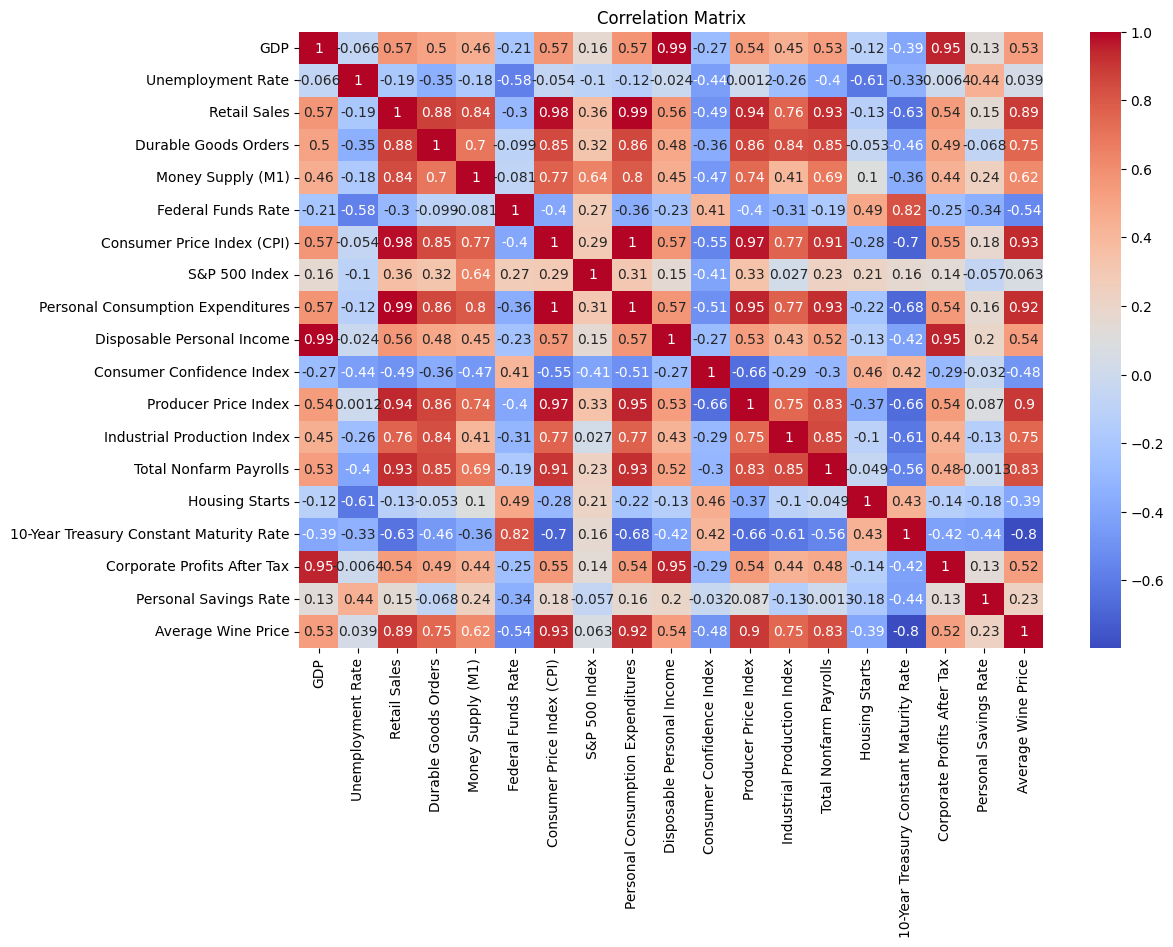

Linear Regression trained.
Ridge Regression trained.
Lasso Regression trained.
K-Nearest Neighbors trained.
Neural Network trained.
Support Vector Machine (RBF Kernel) trained.
Decision Tree trained.
Random Forest trained.
Gradient Boosting trained.
XGBoost trained.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002190 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1287
[LightGBM] [Info] Number of data points in the train set: 275, number of used features: 18
[LightGBM] [Info] Start training from score 9.428059
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No 

In [16]:
# Correlation analysis
plt.figure(figsize=(12, 8))
sns.heatmap(scaled_df.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

# Splitting dataset into X and y
y = scaled_df['Average Wine Price']
X = scaled_df.drop(['Average Wine Price'], axis=1)

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=1)

# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": Ridge(),
    "Lasso Regression": Lasso(),
    "K-Nearest Neighbors": KNeighborsRegressor(),
    "Neural Network": MLPRegressor(max_iter=1000),
    "Support Vector Machine (RBF Kernel)": SVR(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "XGBoost": XGBRegressor(),
    "LightGBM": LGBMRegressor(),
    "CatBoost": CatBoostRegressor(verbose=0)
}

# Train and evaluate models
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    results[name] = {'R²': r2, 'RMSE': rmse, 'MAE': mae}
    print(f"{name} trained.")

# Display results in a more readable format
results_df = pd.DataFrame(results).T
print("Model Performance:")
print(results_df)

Best CatBoost parameters: {'depth': 4, 'iterations': 100, 'learning_rate': 0.05}
Best CatBoost R²: 0.92763
Best CatBoost RMSE: 0.80652
Best CatBoost MAE: 0.57210


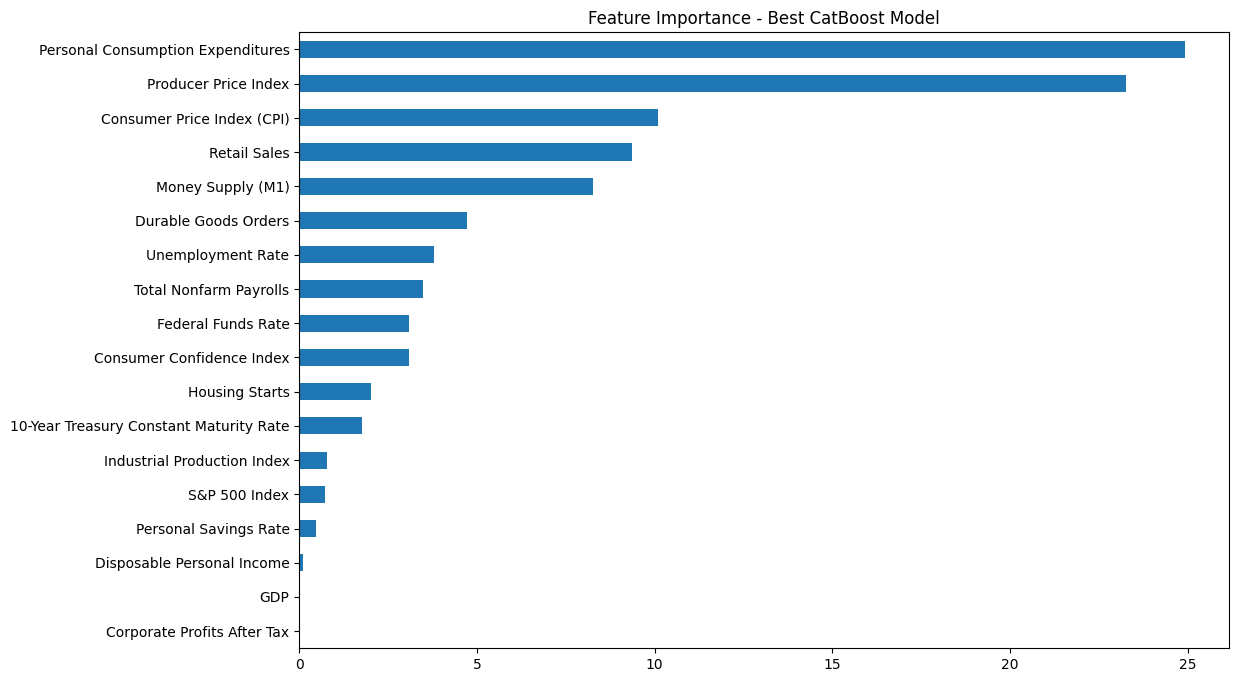

In [21]:
# Hyperparameter tuning for CatBoost
param_grid = {
    'depth': [4, 6, 8],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [100, 200, 300]
}
catboost = CatBoostRegressor(verbose=0)
grid_search = GridSearchCV(estimator=catboost, param_grid=param_grid, cv=5, scoring='r2')
grid_search.fit(X_train, y_train)

best_catboost = grid_search.best_estimator_
print("Best CatBoost parameters:", grid_search.best_params_)

# Evaluate best model
y_pred_best = best_catboost.predict(X_test)
r2_best = r2_score(y_test, y_pred_best)
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)

print(f"Best CatBoost R²: {r2_best:.5f}")
print(f"Best CatBoost RMSE: {rmse_best:.5f}")
print(f"Best CatBoost MAE: {mae_best:.5f}")

# Visualize feature importance for the best model
feature_importance = pd.Series(best_catboost.feature_importances_, index=X.columns)
plt.figure(figsize=(12, 8))
feature_importance.sort_values().plot(kind='barh')
plt.title('Feature Importance - Best CatBoost Model')
plt.savefig('Feature_Importance.png')
plt.show()

Model Performance:
                                           R²      RMSE       MAE
Linear Regression                    0.931476  0.784777  0.592289
Ridge Regression                     0.933141  0.775183  0.579928
Lasso Regression                     0.796548  1.352243  1.229231
K-Nearest Neighbors                  0.936607  0.754820  0.520667
Neural Network                       0.881365  1.032596  0.689008
Support Vector Machine (RBF Kernel)  0.920983  0.842720  0.588086
Decision Tree                        0.885355  1.015083  0.631989
Random Forest                        0.921696  0.838914  0.578284
Gradient Boosting                    0.923417  0.829642  0.553875
XGBoost                              0.881757  1.030887  0.668905
LightGBM                             0.920054  0.847664  0.587809
CatBoost                             0.901636  0.940249  0.620304
Best CatBoost parameters: {'depth': 4, 'iterations': 100, 'learning_rate': 0.05}
Best CatBoost R²: 0.92763
Best CatBoost RM

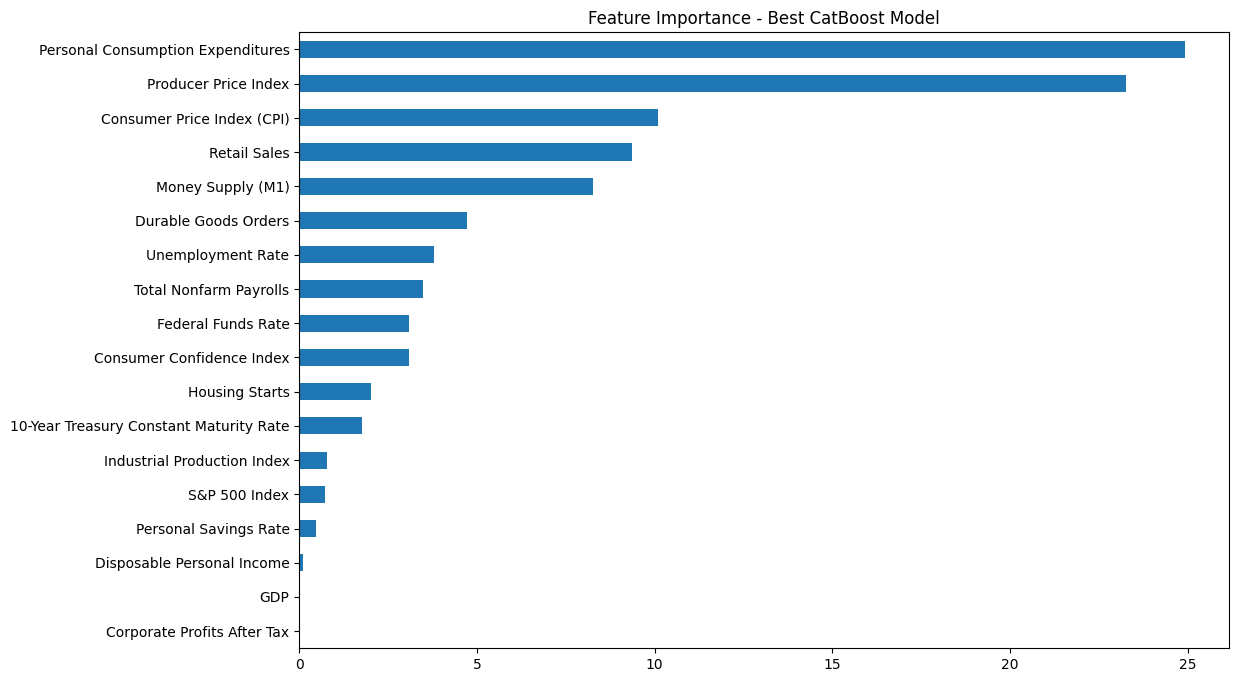

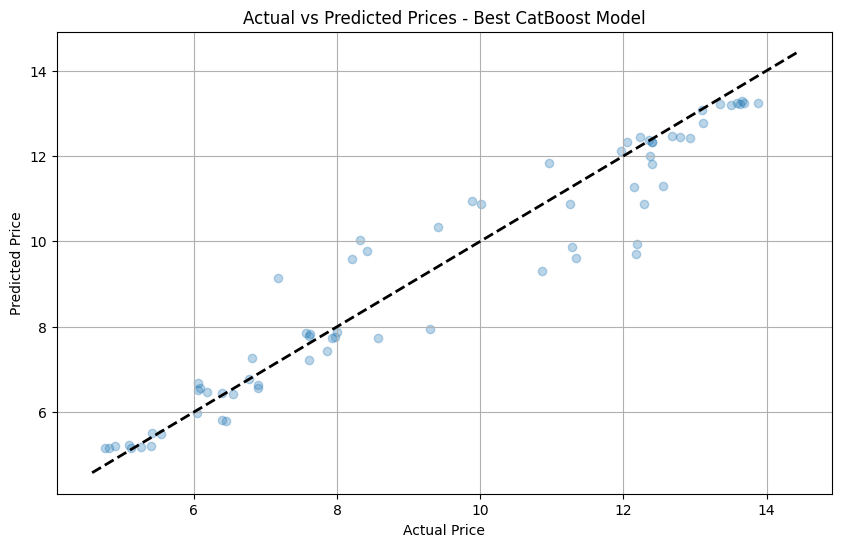

Cross-validated R² scores: [-12.72010607   0.38616064  -0.15333489  -0.4877413   -3.76434998]
Mean cross-validated R² score: -3.34787
Train R²: 0.95564, Test R²: 0.92763
Train RMSE: 0.64070, Test RMSE: 0.80652
Train MAE: 0.45908, Test MAE: 0.57210


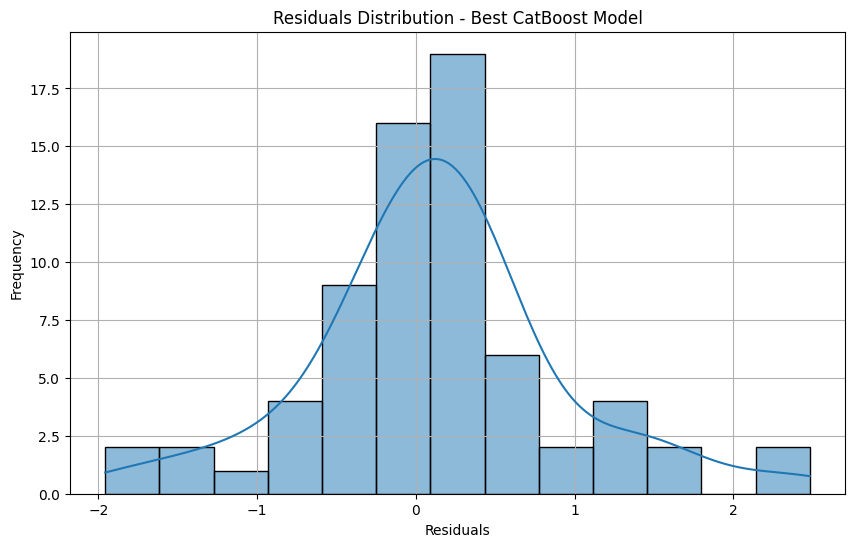

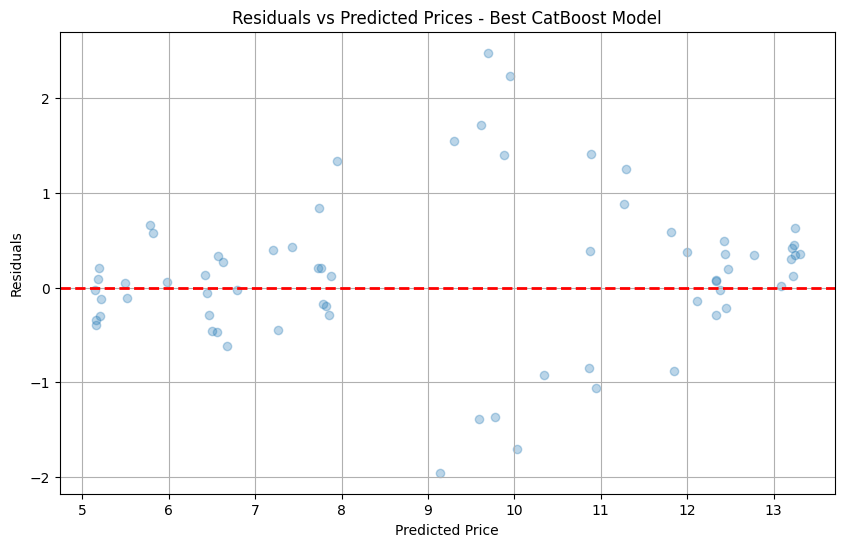

In [19]:
# Plot actual vs. predicted prices for the best model
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Actual vs Predicted Prices - Best CatBoost Model')
plt.grid(True)
plt.savefig('actual_vs_predicted.png')
plt.show()

# Cross-validation for model robustness
cv_results = cross_val_score(best_catboost, X, y, cv=5, scoring='r2')
print(f"Cross-validated R² scores: {cv_results}")
print(f"Mean cross-validated R² score: {cv_results.mean():.5f}")

# Additional metrics for deeper statistical analysis
def evaluate_model(model, X_train, X_test, y_train, y_test):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    train_r2 = r2_score(y_train, y_train_pred)
    test_r2 = r2_score(y_test, y_test_pred)

    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

    train_mae = mean_absolute_error(y_train, y_train_pred)
    test_mae = mean_absolute_error(y_test, y_test_pred)

    print(f"Train R²: {train_r2:.5f}, Test R²: {test_r2:.5f}")
    print(f"Train RMSE: {train_rmse:.5f}, Test RMSE: {test_rmse:.5f}")
    print(f"Train MAE: {train_mae:.5f}, Test MAE: {test_mae:.5f}")

# Evaluate the best model on training and testing data
evaluate_model(best_catboost, X_train, X_test, y_train, y_test)

# Visualize residuals
residuals = y_test - y_pred_best
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.title('Residuals Distribution - Best CatBoost Model')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.grid(True)
plt.savefig('residuals_distribution.png')
plt.show()

# Residuals plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred_best, residuals, alpha=0.3)
plt.axhline(0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Predicted Price')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Prices - Best CatBoost Model')
plt.grid(True)
plt.savefig('residuals_vs_predicted.png')
plt.show()

In [22]:
feature_importance

,0
GDP,0.033426
Unemployment Rate,3.780893
Retail Sales,9.374600
Durable Goods Orders,4.728817
Money Supply (M1),8.253529
Federal Funds Rate,3.100347
Consumer Price Index (CPI),10.095031
S&P 500 Index,0.715177
Personal Consumption Expenditures,24.925194
Disposable Personal Income,0.105243
